# Overview

1. Project Instructions & Prerequisites
2. Learning Objectives
3. Data Preparation
4. Create Categorical Features with TF Feature Columns
5. Create Continuous/Numerical Features with TF Feature Columns
6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers
7. Evaluating Potential Model Biases with Aequitas Toolkit


#  1. Project Instructions & Prerequisites

## Project Instructions

**Context**: EHR data is becoming a key source of real-world evidence (RWE) for the pharmaceutical industry and regulators to [make decisions on clinical trials](https://www.fda.gov/news-events/speeches-fda-officials/breaking-down-barriers-between-clinical-trials-and-clinical-care-incorporating-real-world-evidence). You are a data scientist for an exciting unicorn healthcare startup that has created a groundbreaking diabetes drug that is ready for clinical trial testing. It is a very unique and sensitive drug that requires administering the drug over at least 5-7 days of time in the hospital with frequent monitoring/testing and patient medication adherence training with a mobile application. You have been provided a patient dataset from a client partner and are tasked with building a predictive model that can identify which type of patients the company should focus their efforts testing this drug on. Target patients are people that are likely to be in the hospital for this duration of time and will not incur significant additional costs for administering this drug to the patient and monitoring.  

In order to achieve your goal you must build a regression model that can predict the estimated hospitalization time for a patient and use this to select/filter patients for your study.


**Expected Hospitalization Time Regression Model:** Utilizing a synthetic dataset(denormalized at the line level augmentation) built off of the UCI Diabetes readmission dataset, students will build a regression model that predicts the expected days of hospitalization time and then convert this to a binary prediction of whether to include or exclude that patient from the clinical trial.

This project will demonstrate the importance of building the right data representation at the encounter level, with appropriate filtering and preprocessing/feature engineering of key medical code sets. This project will also require students to analyze and interpret their model for biases across key demographic groups. 

Please see the project rubric online for more details on the areas your project will be evaluated.

### Dataset

Due to healthcare PHI regulations (HIPAA, HITECH), there are limited number of publicly available datasets and some datasets require training and approval. So, for the purpose of this exercise, we are using a dataset from UC Irvine(https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008) that has been modified for this course. Please note that it is limited in its representation of some key features such as diagnosis codes which are usually an unordered list in 835s/837s (the HL7 standard interchange formats used for claims and remits).

**Data Schema**
The dataset reference information can be https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/
. There are two CSVs that provide more details on the fields and some of the mapped values.

## Project Submission 

When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "student_project_submission.ipynb" and save another copy as an HTML file by clicking "File" -> "Download as.."->"html". Include the "utils.py" and "student_utils.py" files in your submission. The student_utils.py should be where you put most of your code that you write and the summary and text explanations should be written inline in the notebook. Once you download these files, compress them into one zip file for submission.

## Prerequisites 

- Intermediate level knowledge of Python
- Basic knowledge of probability and statistics
- Basic knowledge of machine learning concepts
- Installation of Tensorflow 2.0 and other dependencies(conda environment.yml or virtualenv requirements.txt file provided)

## Environment Setup

For step by step instructions on creating your environment, please go to https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/README.md.

# 2.  Learning Objectives

By the end of the project, you will be able to 
   - Use the Tensorflow Dataset API to scalably extract, transform, and load datasets and build datasets aggregated at the line, encounter, and patient data levels(longitudinal)
   - Analyze EHR datasets to check for common issues (data leakage, statistical properties, missing values, high cardinality) by performing exploratory data analysis.
   - Create categorical features from Key Industry Code Sets (ICD, CPT, NDC) and reduce dimensionality for high cardinality features by using embeddings 
   - Create derived features(bucketing, cross-features, embeddings) utilizing Tensorflow feature columns on both continuous and categorical input features
   - SWBAT use the Tensorflow Probability library to train a model that provides uncertainty range predictions that allow for risk adjustment/prioritization and triaging of predictions
   - Analyze and determine biases for a model for key demographic groups by evaluating performance metrics across groups by using the Aequitas framework 


# 3. Data Preparation

In [1]:
# from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import pandas as pd
import aequitas as ae
import warnings 
warnings.filterwarnings('ignore')
# Put all of the helper functions in utils
from utils import build_vocab_files, show_group_stats_viz, aggregate_dataset, preprocess_df, df_to_dataset, posterior_mean_field, prior_trainable
pd.set_option('display.max_columns', 500)
# this allows you to make changes and save in student_utils.py and the file is reloaded every time you run a code block
%load_ext autoreload
%autoreload

In [2]:
#OPEN ISSUE ON MAC OSX for TF model training
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Dataset Loading and Schema Review

Load the dataset and view a sample of the dataset along with reviewing the schema reference files to gain a deeper understanding of the dataset. The dataset is located at the following path https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/starter_code/data/final_project_dataset.csv. Also, review the information found in the data schema https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/

In [3]:
dataset_path = "./data/final_project_dataset.csv"
df = pd.read_csv(dataset_path)

In [4]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO


## Determine Level of Dataset (Line or Encounter)

**Question 1**: Based off of analysis of the data, what level is this dataset? Is it at the line or encounter level? Are there any key fields besides the encounter_id and patient_nbr fields that we should use to aggregate on? Knowing this information will help inform us what level of aggregation is necessary for future steps and is a step that is often overlooked. 

In [5]:
# count, dtypes of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143424 entries, 0 to 143423
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              143424 non-null  int64 
 1   patient_nbr               143424 non-null  int64 
 2   race                      143424 non-null  object
 3   gender                    143424 non-null  object
 4   age                       143424 non-null  object
 5   weight                    143424 non-null  object
 6   admission_type_id         143424 non-null  int64 
 7   discharge_disposition_id  143424 non-null  int64 
 8   admission_source_id       143424 non-null  int64 
 9   time_in_hospital          143424 non-null  int64 
 10  payer_code                143424 non-null  object
 11  medical_specialty         143424 non-null  object
 12  primary_diagnosis_code    143424 non-null  object
 13  other_diagnosis_codes     143424 non-null  object
 14  numb

In [6]:
print("encounter_id", df["encounter_id"].nunique())
print("patient_nbr", df["patient_nbr"].nunique())

print("primary_diagnosis_code", df.primary_diagnosis_code.nunique())
print("rows", df.shape[0])

encounter_id 101766
patient_nbr 71518
primary_diagnosis_code 717
rows 143424


Student Response:??

Because there are more records than encounters, the dataset is at the line level. For each patient, there are also additoinal encounters 

## Analyze Dataset

**Question 2**: Utilizing the library of your choice (recommend Pandas and Seaborn or matplotlib though), perform exploratory data analysis on the dataset. In particular be sure to address the following questions:  
    - a. Field(s) with high amount of missing/zero values
    - b. Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?
    - c. Which field(s) have high cardinality and why (HINT: ndc_code is one feature)
    - d. Please describe the demographic distributions in the dataset for the age and gender fields.
    


###### - a. Field(s) with high amount of missing/zero values

In [7]:
# First 50 rows
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO


In [8]:
# Check the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143424 entries, 0 to 143423
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              143424 non-null  int64 
 1   patient_nbr               143424 non-null  int64 
 2   race                      143424 non-null  object
 3   gender                    143424 non-null  object
 4   age                       143424 non-null  object
 5   weight                    143424 non-null  object
 6   admission_type_id         143424 non-null  int64 
 7   discharge_disposition_id  143424 non-null  int64 
 8   admission_source_id       143424 non-null  int64 
 9   time_in_hospital          143424 non-null  int64 
 10  payer_code                143424 non-null  object
 11  medical_specialty         143424 non-null  object
 12  primary_diagnosis_code    143424 non-null  object
 13  other_diagnosis_codes     143424 non-null  object
 14  numb

In [9]:
# NaNs values at the first sight 
df.isnull().sum()

encounter_id                    0
patient_nbr                     0
race                            0
gender                          0
age                             0
weight                          0
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                      0
medical_specialty               0
primary_diagnosis_code          0
other_diagnosis_codes           0
number_outpatient               0
number_inpatient                0
number_emergency                0
num_lab_procedures              0
number_diagnoses                0
num_medications                 0
num_procedures                  0
ndc_code                    23462
max_glu_serum                   0
A1Cresult                       0
change                          0
readmitted                      0
dtype: int64

In [10]:
# Let's harmonized the columns to re-evalute NaNs
# copy dataset 
df_nan=df.copy()
# Let's replace the ponctuation ? and None by NaN 
df_nan=df_nan.replace('?', np.nan).replace('None', np.nan)
# And compute the NaN average 
nan_mean=df_nan.isnull().mean().sort_values(ascending=False)
nan_mean[nan_mean>0]

weight                    0.970005
max_glu_serum             0.951089
A1Cresult                 0.820295
medical_specialty         0.484319
payer_code                0.377831
ndc_code                  0.163585
race                      0.023071
primary_diagnosis_code    0.000230
dtype: float64

As you can see the following columns have hight amount of missing or Zero values accordingly : weight, max_glu_serum, A1Cresult, medical_specialty, payer_code, ndc_code, race, primary_diagnosis_code.

###### - b. Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?

In [11]:
df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
primary_diagnosis_code      object
other_diagnosis_codes       object
number_outpatient            int64
number_inpatient             int64
number_emergency             int64
num_lab_procedures           int64
number_diagnoses             int64
num_medications              int64
num_procedures               int64
ndc_code                    object
max_glu_serum               object
A1Cresult                   object
change                      object
readmitted                  object
dtype: object

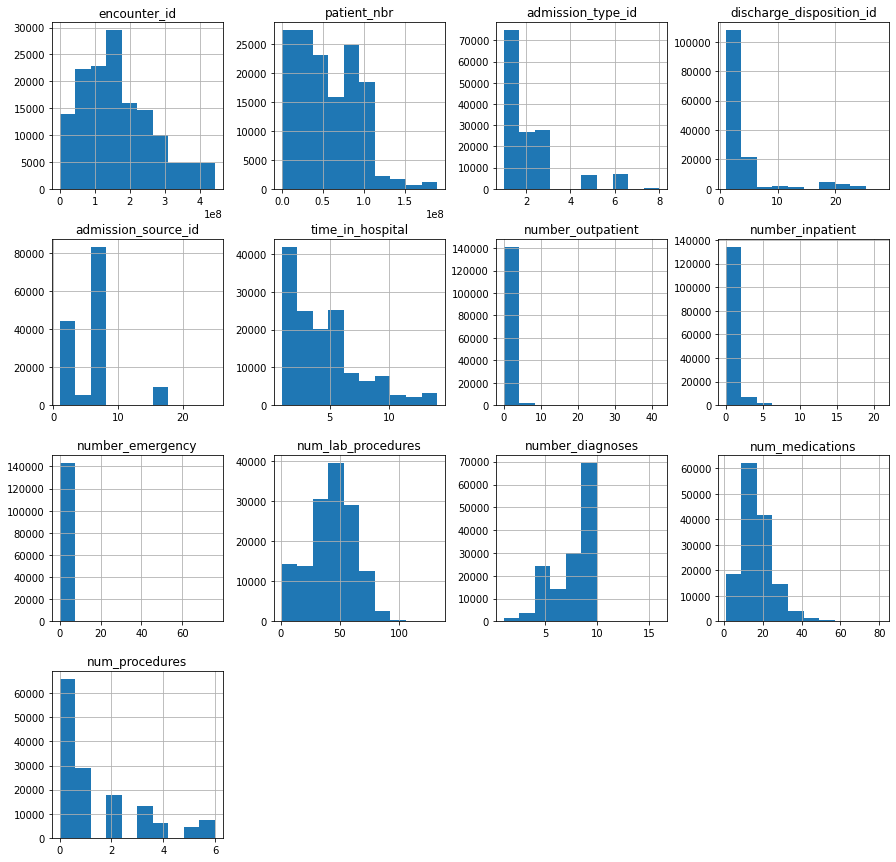

In [12]:
numerical_col=[col for col in df.columns if df[col].dtype!='object']
df[numerical_col].hist(figsize=(15,15))
plt.show()

The features with a gaussian distribution are encounter_id, num_medications, num_lab_procedures and time_in_hospital.

###### Which field(s) have high cardinality and why? (HINT: ndc_code is one feature)

In [13]:
import seaborn as sns
cat_col=[col for col in df.columns if df[col].dtypes=='object']
df[cat_col].nunique().sort_values(ascending=False)

other_diagnosis_codes     19374
primary_diagnosis_code      717
ndc_code                    251
medical_specialty            73
payer_code                   18
age                          10
weight                       10
race                          6
max_glu_serum                 4
A1Cresult                     4
gender                        3
readmitted                    3
change                        2
dtype: int64

The following features have high cardinality : other_diagnosis_codes, primary_diagnosis_code, ndc_code

In [14]:
# Let's check if we have some dirty data in categorical columns
for col in cat_col:
  print('{} has {} values'.format(col, df[col].unique()))
  print('\n')

race has ['Caucasian' 'AfricanAmerican' '?' 'Other' 'Asian' 'Hispanic'] values


gender has ['Female' 'Male' 'Unknown/Invalid'] values


age has ['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)'] values


weight has ['?' '[75-100)' '[50-75)' '[0-25)' '[100-125)' '[25-50)' '[125-150)'
 '[175-200)' '[150-175)' '>200'] values


payer_code has ['?' 'MC' 'MD' 'HM' 'UN' 'BC' 'SP' 'CP' 'SI' 'DM' 'CM' 'CH' 'PO' 'WC' 'OT'
 'OG' 'MP' 'FR'] values


medical_specialty has ['Pediatrics-Endocrinology' '?' 'InternalMedicine'
 'Family/GeneralPractice' 'Cardiology' 'Surgery-General' 'Orthopedics'
 'Gastroenterology' 'Surgery-Cardiovascular/Thoracic' 'Nephrology'
 'Orthopedics-Reconstructive' 'Psychiatry' 'Emergency/Trauma'
 'Pulmonology' 'Surgery-Neuro' 'Obsterics&Gynecology-GynecologicOnco'
 'ObstetricsandGynecology' 'Pediatrics' 'Hematology/Oncology'
 'Otolaryngology' 'Surgery-Colon&Rectal' 'Pediatrics-CriticalCare'
 'Endocrinology' 'Urology' 'Psych

 As you can see we have some dirty data in the categorical columns for instance gender has three values : 'Female' 'Male' 'Unknown/Invalid', and race : 'Caucasian' 'AfricanAmerican' '?' 'Other' 'Asian' 'Hispanic'

In [15]:
# Let's the number observations we have gender within the dirty data 
# filter "unkown" so we have only patients with a valid gender value left
print("Before:", df.shape[0])

is_valid = df['gender'] != "Unknown/Invalid"
df = df[is_valid]

print("After", df.shape[0])

Before: 143424
After 143419


###### - d. Please describe the demographic distributions in the dataset for the age and gender fields.

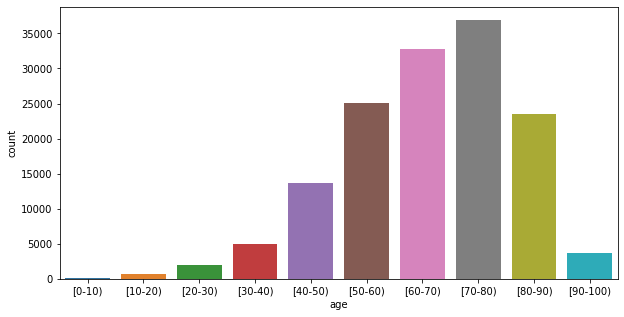

In [16]:
# Age range distribution 
plt.figure(figsize=(10, 5))
sns.countplot(x='age', data=df)
plt.show()

In [17]:
# Let's compute the number of patients and the corresponding percentage of patient
df_age = pd.DataFrame([], columns = ['Number of Patient']) 
df_age['Number of Patient'] = df['age'].value_counts()
df_age['Percentage of Patient'] = df['age'].value_counts(normalize=True)
df_age

,Number of Patient,Percentage of Patient
[70-80),36924,0.257455
[60-70),32740,0.228282
[50-60),25095,0.174977
[80-90),23527,0.164044
[40-50),13729,0.095727
[30-40),4964,0.034612
[90-100),3619,0.025234
[20-30),1927,0.013436
[10-20),733,0.005111
[0-10),161,0.001123


In [18]:
# Number of patient by Gender 
df_gender = pd.DataFrame([], columns = ['Number of Patient']) 
df_gender['Number of Patient'] = df['gender'].value_counts()
df_gender['Percentage of Patient'] = df['gender'].value_counts(normalize=True)
df_gender

,Number of Patient,Percentage of Patient
Female,76185,0.531206
Male,67234,0.468794


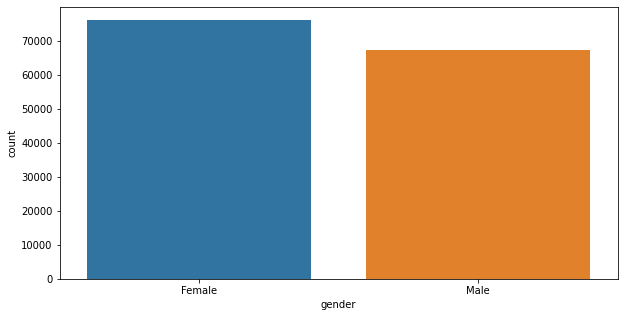

In [19]:
# Gender distribution
plt.figure(figsize=(10, 5))
sns.countplot(x='gender', data=df);

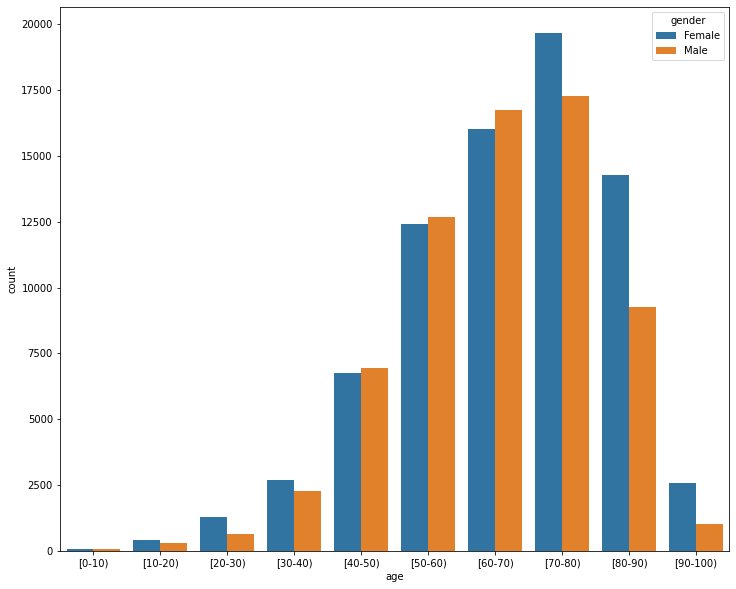

In [20]:
# distribution across both age and gender
plt.figure(figsize=(12, 10))
sns.countplot(x="age", hue="gender", data=df)
plt.show()

- The majority of patients are between the age group of 40 to 90 which represent of 36928 (25%) of the age group 70-80.

- There more female than male patients (53% vs 46%)

**OPTIONAL**: Use the Tensorflow Data Validation and Analysis library to complete. 
- The Tensorflow Data Validation and Analysis library(https://www.tensorflow.org/tfx/data_validation/get_started) is a useful tool for analyzing and summarizing dataset statistics. It is especially useful because it can scale to large datasets that do not fit into memory. 
- Note that there are some bugs that are still being resolved with Chrome v80 and we have moved away from using this for the project. 

**Student Response**: ??

In [21]:
######NOTE: The visualization will only display in Chrome browser. ########
#import tensorflow_data_validation as tfdv
#import tensorflow_data_validation as tfdv
#from tensorflow.python.lib.io import file_io
#from tensorflow_transform.tf_metadata import metadata_io
#full_data_stats = tfdv.generate_statistics_from_csv(data_location='./data/final_project_dataset.csv') 
#tfdv.visualize_statistics(full_data_stats)

## Reduce Dimensionality of the NDC Code Feature

**Question 3**: NDC codes are a common format to represent the wide variety of drugs that are prescribed for patient care in the United States. The challenge is that there are many codes that map to the same or similar drug. You are provided with the ndc drug lookup file https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/ndc_lookup_table.csv derived from the National Drug Codes List site(https://ndclist.com/). Please use this file to come up with a way to reduce the dimensionality of this field and create a new field in the dataset called "generic_drug_name" in the output dataframe. 

In [22]:
#NDC code lookup file
ndc_code_path = "./medication_lookup_tables/final_ndc_lookup_table"
ndc_code_df = pd.read_csv(ndc_code_path)

In [23]:

ndc_code_df.sample(3)

,NDC_Code,Proprietary Name,Non-proprietary Name,Dosage Form,Route Name,Company Name,Product Type
210,0093-8034,Glyburide,Glyburide,Tablet,Oral,"Teva Pharmaceuticals Usa, Inc.",Human Prescription Drug
71,33342-176,Pioglitazole And Metformin Hydrochloride,Pioglitazole And Metformin Hydrochloride,Tablet,Oral,Macleods Pharmaceuticals Limited,Human Prescription Drug
192,53217-320,Glimepiride,Glimepiride,Tablet,Oral,Aidarex Pharmaceuticals Llc,Human Prescription Drug


In [24]:
def reduce_dimension_ndc(df, ndc_df):
    '''
    df: pandas dataframe, input dataset
    ndc_df: pandas dataframe, drug code dataset used for mapping in generic names
    return:
        df: pandas dataframe, output dataframe with joined generic drug name
    '''
    return_df = df.copy()
    return_df = return_df.merge(
        ndc_df[['NDC_Code', 'Proprietary Name']], left_on='ndc_code', right_on='NDC_Code')
    return_df['generic_drug_name'] = return_df['Proprietary Name']
    del return_df["NDC_Code"]
    del return_df["Proprietary Name"]
    return return_df

In [25]:
#from student_utils import reduce_dimension_ndc

In [26]:
reduce_dim_df = reduce_dimension_ndc(df, ndc_code_df)

In [27]:
reduce_dim_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name
0,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30,Novolin R
1,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO,Novolin R
2,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,68071-1701,None,None,Ch,NO,Novolin R
3,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,434,198|486,0,0,0,33,8,18,3,68071-1701,None,None,Ch,NO,Novolin R
4,28236,89869032,AfricanAmerican,Female,[40-50),?,1,1,7,9,?,?,250.7,403|996,0,0,0,47,9,17,2,68071-1701,None,None,No,>30,Novolin R


In [28]:
# Number of unique values should be less for the new output field
assert df['ndc_code'].nunique() > reduce_dim_df['generic_drug_name'].nunique()

## Select First Encounter for each Patient 

**Question 4**: In order to simplify the aggregation of data for the model, we will only select the first encounter for each patient in the dataset. This is to reduce the risk of data leakage of future patient encounters and to reduce complexity of the data transformation and modeling steps. We will assume that sorting in numerical order on the encounter_id provides the time horizon for determining which encounters come before and after another.

In [29]:
def select_first_encounter(df):
    '''
    df: pandas dataframe, dataframe with all encounters
    return:
        - first_encounter_df: pandas dataframe, dataframe with only the first encounter for a given patient
    '''
    ## sort the df by encouter_id (lowest encouter_id is first)
    df.sort_values('encounter_id')
    ## get the first encouter for each patient
    first_encounter_value = df.groupby('patient_nbr')['encounter_id'].head(1).values
    ## return the filtered df with the first encouter for each patient
    return df[df['encounter_id'].isin(first_encounter_value)]

In [30]:
#from student_utils import select_first_encounter
first_encounter_df = select_first_encounter(reduce_dim_df)

In [31]:
# unique patients in transformed dataset
unique_patients = first_encounter_df['patient_nbr'].nunique()
print("Number of unique patients:{}".format(unique_patients))

# unique encounters in transformed dataset
unique_encounters = first_encounter_df['encounter_id'].nunique()
print("Number of unique encounters:{}".format(unique_encounters))

original_unique_patient_number = reduce_dim_df['patient_nbr'].nunique()
# number of unique patients should be equal to the number of unique encounters and patients in the final dataset
assert original_unique_patient_number == unique_patients
assert original_unique_patient_number == unique_encounters
print("Tests passed!!")

Number of unique patients:56131
Number of unique encounters:56131
Tests passed!!


## Aggregate Dataset to Right Level for Modeling 

In order to provide a broad scope of the steps and to prevent students from getting stuck with data transformations, we have selected the aggregation columns and provided a function to build the dataset at the appropriate level. The 'aggregate_dataset" function that you can find in the 'utils.py' file can take the preceding dataframe with the 'generic_drug_name' field and transform the data appropriately for the project. 

To make it simpler for students, we are creating dummy columns for each unique generic drug name and adding those are input features to the model. There are other options for data representation but this is out of scope for the time constraints of the course.

In [32]:
first_encounter_df.sample(3)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name
115329,174889968,48692646,Caucasian,Male,[70-80),?,1,1,7,5,?,InternalMedicine,453,250.02|413,0,0,0,41,9,14,2,43063-697,None,None,Ch,NO,Glimepiride
114654,85751448,22900473,Other,Male,[70-80),?,3,6,1,5,?,Surgery-Thoracic,414,428|285,0,0,0,46,7,34,2,0904-6326,None,None,Ch,NO,Metformin Hydrochloride
7123,122701926,94760019,Caucasian,Female,[50-60),?,3,1,1,6,?,Surgery-General,553,518|997,0,0,0,9,9,13,2,68071-1701,None,None,No,>30,Novolin R


In [33]:
exclusion_list = ['generic_drug_name']
grouping_field_list = [c for c in first_encounter_df.columns if c not in exclusion_list]
agg_drug_df, ndc_col_list = aggregate_dataset(first_encounter_df, grouping_field_list, 'generic_drug_name')

In [34]:
grouping_field_list

['encounter_id',
 'patient_nbr',
 'race',
 'gender',
 'age',
 'weight',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'payer_code',
 'medical_specialty',
 'primary_diagnosis_code',
 'other_diagnosis_codes',
 'number_outpatient',
 'number_inpatient',
 'number_emergency',
 'num_lab_procedures',
 'number_diagnoses',
 'num_medications',
 'num_procedures',
 'ndc_code',
 'max_glu_serum',
 'A1Cresult',
 'change',
 'readmitted']

In [35]:
ndc_col_list

['Acarbose',
 'Afrezza',
 'Amaryl',
 'Avandia_2MG',
 'Avandia_4MG',
 'Duetact',
 'Glimepiride',
 'Glipizide',
 'Glipizide_And_Metformin_Hcl',
 'Glipizide_And_Metformin_Hydrochloride',
 'Glucophage',
 'Glucophage_XR',
 'Glucotrol',
 'Glucotrol_XL',
 'Glyburide',
 'Glyburide_And_Metformin_Hydrochloride',
 'Glyburide-metformin_Hydrochloride',
 'Glynase',
 'Glyset',
 'Humulin_R',
 'Metformin_Hcl',
 'Metformin_Hydrochloride',
 'Metformin_Hydrochloride_Extended_Release',
 'Miglitol',
 'Nateglinide',
 'Novolin_R',
 'Pioglitazole_And_Metformin_Hydrochloride',
 'Pioglitazone',
 'Pioglitazone_Hydrochloride_And_Glimepiride',
 'Prandin',
 'Repaglinide',
 'Riomet',
 'Riomet_Er',
 'Starlix',
 'Tolazamide',
 'Tolbutamide']

In [36]:
# Total drug
len(agg_drug_df)

87661

In [37]:
# Total drug at patient level
agg_drug_df['patient_nbr'].nunique()

56131

In [38]:
# Total drug at encoundter level
agg_drug_df['encounter_id'].nunique()

56131

In [39]:
#assert len(agg_drug_df) == agg_drug_df['patient_nbr'].nunique() == agg_drug_df['encounter_id'].nunique()

In [40]:
agg_drug_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name_array,Acarbose,Afrezza,Amaryl,Avandia_2MG,Avandia_4MG,Duetact,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glucophage,Glucophage_XR,Glucotrol,Glucotrol_XL,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Glynase,Glyset,Humulin_R,Metformin_Hcl,Metformin_Hydrochloride,Metformin_Hydrochloride_Extended_Release,Miglitol,Nateglinide,Novolin_R,Pioglitazole_And_Metformin_Hydrochloride,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Prandin,Repaglinide,Riomet,Riomet_Er,Starlix,Tolazamide,Tolbutamide
0,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,398,427|38,0,0,0,68,8,28,2,0049-4110,None,None,Ch,NO,[Glucotrol],0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,398,427|38,0,0,0,68,8,28,2,47918-902,None,None,Ch,NO,[Afrezza],0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,434,198|486,0,0,0,33,8,18,3,0173-0863,None,None,Ch,NO,[Avandia 4MG],0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,434,198|486,0,0,0,33,8,18,3,68071-1701,None,None,Ch,NO,[Novolin R],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO,[Glucotrol],0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Prepare Fields and Cast Dataset 

### Feature Selection

**Question 5**: After you have aggregated the dataset to the right level, we can do feature selection (we will include the ndc_col_list, dummy column features too). In the block below, please select the categorical and numerical features that you will use for the model, so that we can create a dataset subset. 

For the payer_code and weight fields, please provide whether you think we should include/exclude the field in our model and give a justification/rationale for this based off of the statistics of the data. Feel free to use visualizations or summary statistics to support your choice.

In [41]:
# Check NaNs
agg_drug_df.isnull().sum()

encounter_id    0
patient_nbr     0
race            0
gender          0
age             0
               ..
Riomet          0
Riomet_Er       0
Starlix         0
Tolazamide      0
Tolbutamide     0
Length: 63, dtype: int64

In [42]:
nan_mean=agg_drug_df.isnull().mean().sort_values(ascending=False)
nan_mean[nan_mean>0]

Series([], dtype: float64)

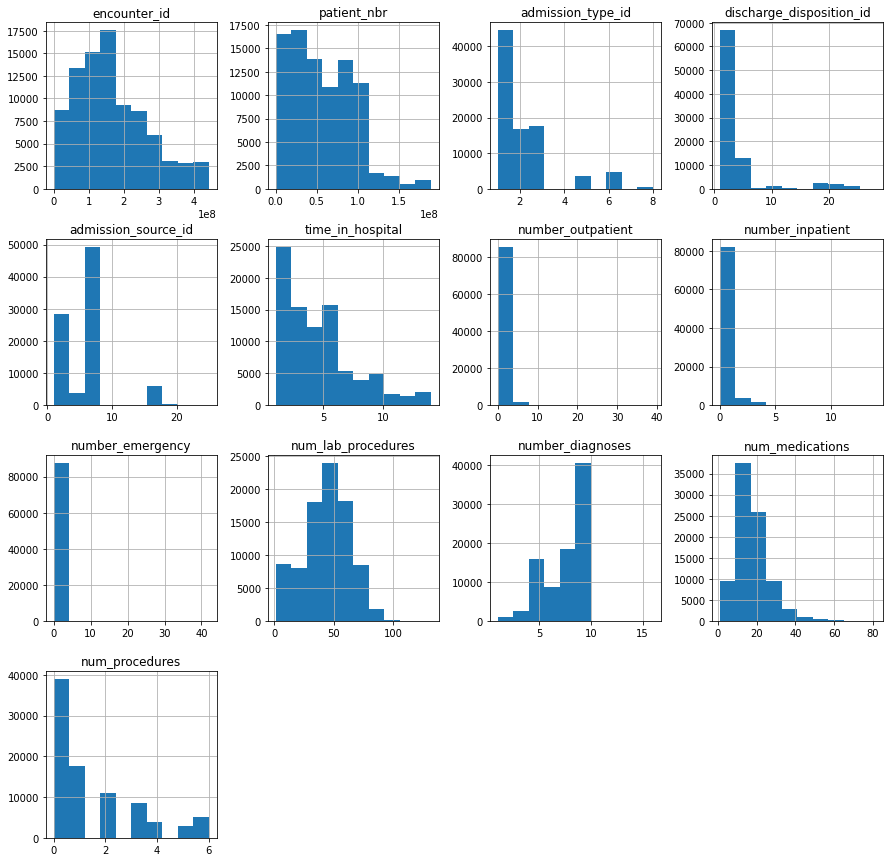

In [43]:
# Distribution of numerical values
num_col=[col for col in df.columns if df[col].dtype!='object']
agg_drug_df[num_col].hist(figsize=(15,15))
plt.show()

In [44]:
agg_drug_df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'primary_diagnosis_code', 'other_diagnosis_codes', 'number_outpatient',
       'number_inpatient', 'number_emergency', 'num_lab_procedures',
       'number_diagnoses', 'num_medications', 'num_procedures', 'ndc_code',
       'max_glu_serum', 'A1Cresult', 'change', 'readmitted',
       'generic_drug_name_array', 'Acarbose', 'Afrezza', 'Amaryl',
       'Avandia_2MG', 'Avandia_4MG', 'Duetact', 'Glimepiride', 'Glipizide',
       'Glipizide_And_Metformin_Hcl', 'Glipizide_And_Metformin_Hydrochloride',
       'Glucophage', 'Glucophage_XR', 'Glucotrol', 'Glucotrol_XL', 'Glyburide',
       'Glyburide_And_Metformin_Hydrochloride',
       'Glyburide-metformin_Hydrochloride', 'Glynase', 'Glyset', 'Humulin_R',
       'Metformin_Hcl', 'Metformin_Hydrochloride',
       'Metformin_Hydr

In [45]:
agg_drug_df.dtypes

encounter_id     int64
patient_nbr      int64
race            object
gender          object
age             object
                 ...  
Riomet           uint8
Riomet_Er        uint8
Starlix          uint8
Tolazamide       uint8
Tolbutamide      uint8
Length: 63, dtype: object

In [46]:
def hist_features(col, bins=None):
    if bins is None:
        df[col].hist(bins=df[col].nunique())
    else:
        df[col].hist(bins=bins)

In [47]:
# Info agg_drug_df
agg_drug_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87661 entries, 0 to 87660
Data columns (total 63 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   encounter_id                                87661 non-null  int64 
 1   patient_nbr                                 87661 non-null  int64 
 2   race                                        87661 non-null  object
 3   gender                                      87661 non-null  object
 4   age                                         87661 non-null  object
 5   weight                                      87661 non-null  object
 6   admission_type_id                           87661 non-null  int64 
 7   discharge_disposition_id                    87661 non-null  int64 
 8   admission_source_id                         87661 non-null  int64 
 9   time_in_hospital                            87661 non-null  int64 
 10  payer_code            

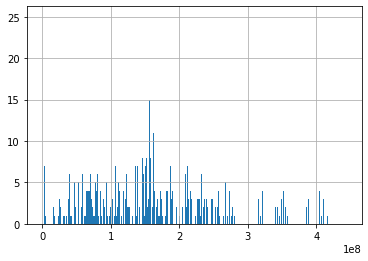

In [48]:
hist_features('encounter_id')

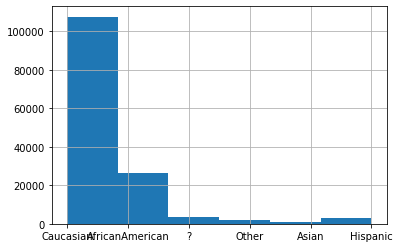

In [49]:
hist_features('race')

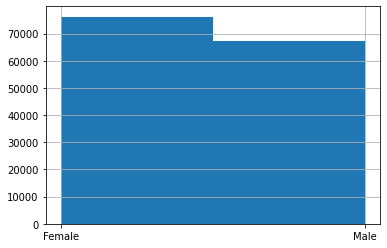

In [50]:
hist_features('gender')

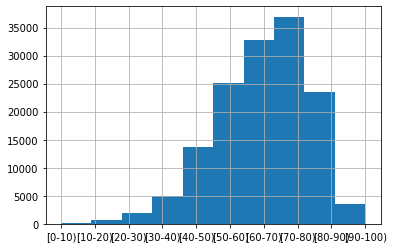

In [51]:
hist_features('age')

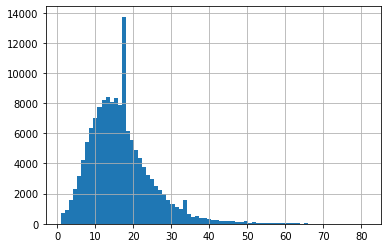

In [52]:
hist_features('num_medications')

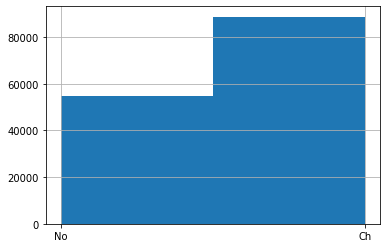

In [53]:
hist_features('change')

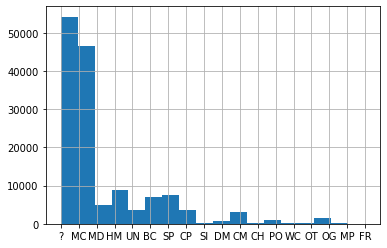

In [54]:
hist_features('payer_code')

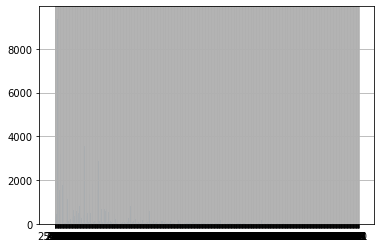

In [55]:
hist_features('primary_diagnosis_code')

 Question 5 - Student response: At the following the features to be included

- race - include, as different races may have different nutritional patterns which could have an effect
- gender - include, as some functions of the body are different for males and females
- age - include, as age definitely has an effect on how the body reacts to drugs
- time_in_hospital - PREDICTOR_FIELD
- primary_diagnosis_code - include, the distribution resembles normal (if codes properly re-arranges on the graph)
- other_diagnosis_codes - include
- num_lab_procedures - include, normal distribution
- num_medications - include, normal distribution

In [56]:
'''
Please update the list to include the features you think are appropriate for the model 
and the field that we will be using to train the model. There are three required demographic features for the model 
and I have inserted a list with them already in the categorical list. 
These will be required for later steps when analyzing data splits and model biases.
'''
required_demo_col_list = ['race', 'gender', 'age']
student_categorical_col_list = [ "primary_diagnosis_code", "other_diagnosis_codes"] + required_demo_col_list + ndc_col_list
student_numerical_col_list = [ "num_lab_procedures", "num_medications"]
PREDICTOR_FIELD = 'time_in_hospital'

In [57]:
def select_model_features(df, categorical_col_list, numerical_col_list, PREDICTOR_FIELD, grouping_key='patient_nbr'):
    selected_col_list = [grouping_key] + [PREDICTOR_FIELD] + categorical_col_list + numerical_col_list   
    return agg_drug_df[selected_col_list]


In [58]:
selected_features_df = select_model_features(agg_drug_df, student_categorical_col_list, student_numerical_col_list,
                                            PREDICTOR_FIELD)

### Preprocess Dataset - Casting and Imputing  

We will cast and impute the dataset before splitting so that we do not have to repeat these steps across the splits in the next step. For imputing, there can be deeper analysis into which features to impute and how to impute but for the sake of time, we are taking a general strategy of imputing zero for only numerical features. 

OPTIONAL: What are some potential issues with this approach? Can you recommend a better way and also implement it?

In [59]:
processed_df = preprocess_df(selected_features_df, student_categorical_col_list, 
        student_numerical_col_list, PREDICTOR_FIELD, categorical_impute_value='nan', numerical_impute_value=0)

In [60]:
processed_df.head()

,patient_nbr,time_in_hospital,primary_diagnosis_code,other_diagnosis_codes,race,gender,age,Acarbose,Afrezza,Amaryl,Avandia_2MG,Avandia_4MG,Duetact,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glucophage,Glucophage_XR,Glucotrol,Glucotrol_XL,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Glynase,Glyset,Humulin_R,Metformin_Hcl,Metformin_Hydrochloride,Metformin_Hydrochloride_Extended_Release,Miglitol,Nateglinide,Novolin_R,Pioglitazole_And_Metformin_Hydrochloride,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Prandin,Repaglinide,Riomet,Riomet_Er,Starlix,Tolazamide,Tolbutamide,num_lab_procedures,num_medications
0,48330783,13.0,398,427|38,Caucasian,Female,[80-90),0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,28
1,48330783,13.0,398,427|38,Caucasian,Female,[80-90),0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,28
2,63555939,12.0,434,198|486,Caucasian,Female,[90-100),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33,18
3,63555939,12.0,434,198|486,Caucasian,Female,[90-100),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,33,18
4,42519267,1.0,197,157|250,Caucasian,Male,[40-50),0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51,8


In [61]:
# Shape 
processed_df.shape

(87661, 45)

## Split Dataset into Train, Validation, and Test Partitions

**Question 6**: In order to prepare the data for being trained and evaluated by a deep learning model, we will split the dataset into three partitions, with the validation partition used for optimizing the model hyperparameters during training. One of the key parts is that we need to be sure that the data does not accidently leak across partitions.

Please complete the function below to split the input dataset into three partitions(train, validation, test) with the following requirements.
- Approximately 60%/20%/20%  train/validation/test split
- Randomly sample different patients into each data partition
- **IMPORTANT** Make sure that a patient's data is not in more than one partition, so that we can avoid possible data leakage.
- Make sure that the total number of unique patients across the splits is equal to the total number of unique patients in the original dataset
- Total number of rows in original dataset = sum of rows across all three dataset partitions

In [62]:
from student_utils import patient_dataset_splitter
d_train, d_val, d_test = patient_dataset_splitter(processed_df, 'patient_nbr')

In [63]:
d_train, d_val, d_test = patient_dataset_splitter(processed_df, 'patient_nbr')

In [64]:
assert len(d_train) + len(d_val) + len(d_test) == len(processed_df)
print("Test passed for number of total rows equal!")

Test passed for number of total rows equal!


In [65]:
#assert (d_train['patient_nbr'].nunique() + d_val['patient_nbr'].nunique() + d_test['patient_nbr'].nunique()) == agg_drug_df['patient_nbr'].nunique()
#print("Test passed for number of unique patients being equal!")

In [66]:
# Shape 
processed_df.shape

(87661, 45)

In [67]:
print(f'Train/Validation/Test number of records: {len(d_train)}/{len(d_val)}/{len(d_test)}')

Train/Validation/Test number of records: 52596/17532/17533


###### Question 6  Student Responsse 

Data split between train/validation/test sets approx. 60%/20%/20% with number of records: 32562/10854/10855

## Demographic Representation Analysis of Split

After the split, we should check to see the distribution of key features/groups and make sure that there is representative samples across the partitions. The show_group_stats_viz function in the utils.py file can be used to group and visualize different groups and dataframe partitions.

### Label Distribution Across Partitions

Below you can see the distributution of the label across your splits. Are the histogram distribution shapes similar across partitions?

time_in_hospital
1.0     10810
2.0     14087
3.0     15437
4.0     12225
5.0      9041
6.0      6692
7.0      5288
8.0      3992
9.0      2790
10.0     2062
11.0     1735
12.0     1364
13.0     1189
14.0      949
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


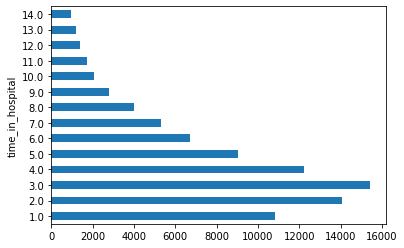

In [68]:
show_group_stats_viz(processed_df, PREDICTOR_FIELD)

time_in_hospital
1.0     6486
2.0     8452
3.0     9262
4.0     7335
5.0     5425
6.0     4015
7.0     3173
8.0     2395
9.0     1674
10.0    1237
11.0    1041
12.0     818
13.0     713
14.0     570
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


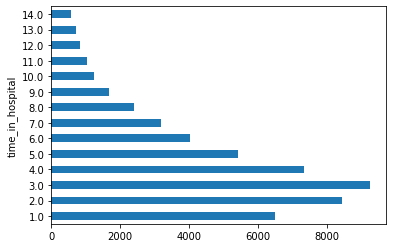

In [69]:
show_group_stats_viz(d_train, PREDICTOR_FIELD)

time_in_hospital
1.0     2162
2.0     2818
3.0     3088
4.0     2445
5.0     1808
6.0     1339
7.0     1058
8.0      798
9.0      558
10.0     412
11.0     347
12.0     273
13.0     238
14.0     189
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


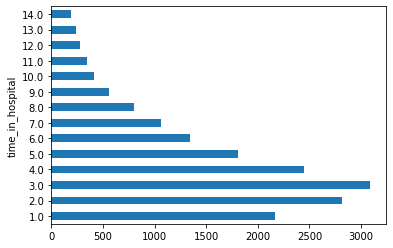

In [70]:
show_group_stats_viz(d_test, PREDICTOR_FIELD)

## Demographic Group Analysis

We should check that our partitions/splits of the dataset are similar in terms of their demographic profiles. Below you can see how we might visualize and analyze the full dataset vs. the partitions.

gender
Female    29582
Male      26549
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


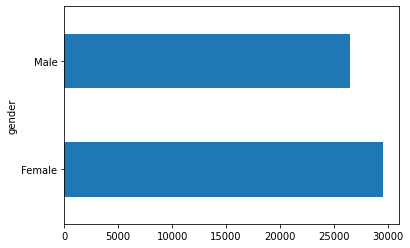

In [71]:
# Full dataset before splitting
patient_demo_features = ['race', 'gender', 'age', 'patient_nbr']
patient_group_analysis_df = processed_df[patient_demo_features].groupby('patient_nbr').head(1).reset_index(drop=True)
show_group_stats_viz(patient_group_analysis_df, 'gender')

gender
Female    27397
Male      25199
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


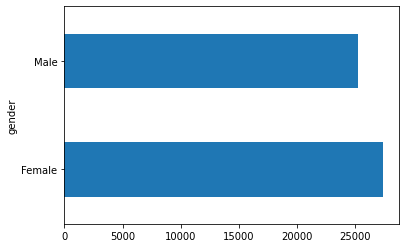

In [72]:
# Training partition
show_group_stats_viz(d_train, 'gender')

gender
Female    9154
Male      8379
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


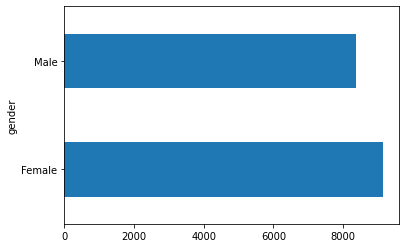

In [73]:
# Test partition
show_group_stats_viz(d_test, 'gender')

## Convert Dataset Splits to TF Dataset

We have provided you the function to convert the Pandas dataframe to TF tensors using the TF Dataset API. 
Please note that this is not a scalable method and for larger datasets, the 'make_csv_dataset' method is recommended -https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset.

In [74]:
# Convert dataset from Pandas dataframes to TF dataset 
batch_size = 128
diabetes_train_ds = df_to_dataset(d_train, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_val_ds = df_to_dataset(d_val, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_test_ds = df_to_dataset(d_test, PREDICTOR_FIELD, batch_size=batch_size)

2022-01-19 23:03:16.733973: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [75]:
# We use this sample of the dataset to show transformations later
diabetes_batch = next(iter(diabetes_train_ds))[0]
def demo(feature_column, example_batch):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))

# 4. Create Categorical Features with TF Feature Columns

## Build Vocabulary for Categorical Features

Before we can create the TF categorical features, we must first create the vocab files with the unique values for a given field that are from the **training** dataset. Below we have provided a function that you can use that only requires providing the pandas train dataset partition and the list of the categorical columns in a list format. The output variable 'vocab_file_list' will be a list of the file paths that can be used in the next step for creating the categorical features.

In [77]:
student_categorical_col_list

['primary_diagnosis_code',
 'other_diagnosis_codes',
 'race',
 'gender',
 'age',
 'Acarbose',
 'Afrezza',
 'Amaryl',
 'Avandia_2MG',
 'Avandia_4MG',
 'Duetact',
 'Glimepiride',
 'Glipizide',
 'Glipizide_And_Metformin_Hcl',
 'Glipizide_And_Metformin_Hydrochloride',
 'Glucophage',
 'Glucophage_XR',
 'Glucotrol',
 'Glucotrol_XL',
 'Glyburide',
 'Glyburide_And_Metformin_Hydrochloride',
 'Glyburide-metformin_Hydrochloride',
 'Glynase',
 'Glyset',
 'Humulin_R',
 'Metformin_Hcl',
 'Metformin_Hydrochloride',
 'Metformin_Hydrochloride_Extended_Release',
 'Miglitol',
 'Nateglinide',
 'Novolin_R',
 'Pioglitazole_And_Metformin_Hydrochloride',
 'Pioglitazone',
 'Pioglitazone_Hydrochloride_And_Glimepiride',
 'Prandin',
 'Repaglinide',
 'Riomet',
 'Riomet_Er',
 'Starlix',
 'Tolazamide',
 'Tolbutamide']

In [78]:
import os
os.mkdir('./diabetes_vocab/')

In [79]:
vocab_file_list = build_vocab_files(d_train, student_categorical_col_list)

## Create Categorical Features with Tensorflow Feature Column API

**Question 7**: Using the vocab file list from above that was derived fromt the features you selected earlier, please create categorical features with the Tensorflow Feature Column API, https://www.tensorflow.org/api_docs/python/tf/feature_column. Below is a function to help guide you.

In [80]:
from student_utils import create_tf_categorical_feature_cols
tf_cat_col_list = create_tf_categorical_feature_cols(student_categorical_col_list)

INFO:tensorflow:vocabulary_size = 624 in primary_diagnosis_code is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/primary_diagnosis_code_vocab.txt.
### primary_diagnosis_code: #lines: 624, embedding (categorical)
INFO:tensorflow:vocabulary_size = 10825 in other_diagnosis_codes is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/other_diagnosis_codes_vocab.txt.
### other_diagnosis_codes: #lines: 10825, embedding (categorical)
INFO:tensorflow:vocabulary_size = 7 in race is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/race_vocab.txt.
### race: #lines: 7, indicator (categorical)
INFO:tensorflow:vocabulary_size = 3 in gender is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/gender_vocab.txt.
### gender: #lines: 3, indicator (categorical)
INFO:tensorflow:vocabulary_size = 11 in age is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/age_vocab.txt

In [81]:
test_cat_var1 = tf_cat_col_list[0]
print("Example categorical field:\n{}".format(test_cat_var1))
demo(test_cat_var1, diabetes_batch)

Example categorical field:
EmbeddingColumn(categorical_column=VocabularyFileCategoricalColumn(key='primary_diagnosis_code', vocabulary_file='./diabetes_vocab/primary_diagnosis_code_vocab.txt', vocabulary_size=624, num_oov_buckets=0, dtype=tf.string, default_value=-1, file_format=None), dimension=10, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7feb7bdfdb10>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True, use_safe_embedding_lookup=True)
tf.Tensor(
[[-0.18609793  0.09344763  0.26022696 ...  0.00946887  0.42783067
   0.39223874]
 [-0.40081617 -0.27465406 -0.06644782 ... -0.24886116 -0.20356473
  -0.31869644]
 [-0.15122741  0.18784085 -0.17445071 ... -0.23338896  0.13905936
   0.22481908]
 ...
 [ 0.17402923  0.62673634 -0.14773145 ...  0.38522857  0.1365184
   0.36644533]
 [-0.3878012   0.2903506  -0.22099939 ... -0.24306452 -0.42289725
  -0.12535359]
 [ 0.04962659  0.10020849  0.41910478 ... -0.16557628  0.25266

# 5. Create Numerical Features with TF Feature Columns

**Question 8**: Using the TF Feature Column API(https://www.tensorflow.org/api_docs/python/tf/feature_column/), please create normalized Tensorflow numeric features for the model. Try to use the z-score normalizer function below to help as well as the 'calculate_stats_from_train_data' function.

In [83]:
from student_utils import create_tf_numeric_feature

For simplicity the create_tf_numerical_feature_cols function below uses the same normalizer function across all features(z-score normalization) but if you have time feel free to analyze and adapt the normalizer based off the statistical distributions. You may find this as a good resource in determining which transformation fits best for the data https://developers.google.com/machine-learning/data-prep/transform/normalization.


In [84]:
def calculate_stats_from_train_data(df, col):
    mean = df[col].describe()['mean']
    std = df[col].describe()['std']
    return mean, std

def create_tf_numerical_feature_cols(numerical_col_list, train_df):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        mean, std = calculate_stats_from_train_data(train_df, c)
        tf_numeric_feature = create_tf_numeric_feature(c, mean, std)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list

In [85]:
tf_cont_col_list = create_tf_numerical_feature_cols(student_numerical_col_list, d_train)

### num_lab_procedures: #mean/std: 43.92077344284736/19.912697021502293, numeric (normalized)
### num_medications: #mean/std: 17.434443683930336/8.758340407901409, numeric (normalized)


In [86]:
test_cont_var1 = tf_cont_col_list[0]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, diabetes_batch)

Example continuous field:
NumericColumn(key='num_lab_procedures', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=functools.partial(<function normalize_numeric_with_zscore at 0x7febdcd32710>, mean=43.92077344284736, std=19.912697021502293))

tf.Tensor(
[[-1.7894737 ]
 [ 0.        ]
 [ 0.57894737]
 [-0.57894737]
 [ 0.36842105]
 [ 1.6315789 ]
 [ 0.2631579 ]
 [-0.47368422]
 [-0.2631579 ]
 [-2.1578948 ]
 [ 0.68421054]
 [ 0.47368422]
 [-2.2105262 ]
 [-0.21052632]
 [ 0.2631579 ]
 [ 0.05263158]
 [-0.05263158]
 [-0.15789473]
 [ 0.15789473]
 [-0.2631579 ]
 [ 0.68421054]
 [ 1.0526316 ]
 [ 0.84210527]
 [-0.47368422]
 [-0.94736844]
 [ 0.7894737 ]
 [-0.8947368 ]
 [ 1.2105263 ]
 [ 0.8947368 ]
 [ 1.4210526 ]
 [-2.2105262 ]
 [ 2.2105262 ]
 [-2.2105262 ]
 [ 0.36842105]
 [-1.1052631 ]
 [-2.1578948 ]
 [ 0.6315789 ]
 [-0.94736844]
 [ 1.2105263 ]
 [ 1.5263158 ]
 [-0.47368422]
 [ 0.84210527]
 [ 1.0526316 ]
 [ 1.1578947 ]
 [ 0.05263158]
 [-0.05263158]
 [ 1.9473684 ]
 [ 0.05263158]
 [-0.157894

###### Question 8 Student Reponse : 

Numeric Features created, using 'normalize_numeric_with_zscore' function:

- num_lab_procedures
- num_medications

# 6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers

## Use DenseFeatures to combine features for model

Now that we have prepared categorical and numerical features using Tensorflow's Feature Column API, we can combine them into a dense vector representation for the model. Below we will create this new input layer, which we will call 'claim_feature_layer'.

In [87]:
claim_feature_columns = tf_cat_col_list + tf_cont_col_list
claim_feature_layer = tf.keras.layers.DenseFeatures(claim_feature_columns)

## Build Sequential API Model from DenseFeatures and TF Probability Layers

Below we have provided some boilerplate code for building a model that connects the Sequential API, DenseFeatures, and Tensorflow Probability layers into a deep learning model. There are many opportunities to further optimize and explore different architectures through benchmarking and testing approaches in various research papers, loss and evaluation metrics, learning curves, hyperparameter tuning, TF probability layers, etc. Feel free to modify and explore as you wish.

**OPTIONAL**: Come up with a more optimal neural network architecture and hyperparameters. Share the process in discovering the architecture and hyperparameters.

In [88]:
def build_sequential_model(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(75, activation='relu'),
        tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable),
        tfp.layers.DistributionLambda(
            lambda t:tfp.distributions.Normal(loc=t[..., :1],
                                             scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])
                                             )
        ),
    ])
    return model

def build_diabetes_model(train_ds, val_ds,  feature_layer,  epochs=5, loss_metric='mse'):
    model = build_sequential_model(feature_layer)
    model.compile(optimizer='rmsprop', loss=loss_metric, metrics=[loss_metric])
    early_stop = tf.keras.callbacks.EarlyStopping(monitor=loss_metric, patience=3)     
    history = model.fit(train_ds, validation_data=val_ds,
                        callbacks=[early_stop],
                        epochs=epochs)
    return model, history 

In [89]:
diabetes_model, history = build_diabetes_model(diabetes_train_ds, diabetes_val_ds,  claim_feature_layer,  epochs=10)

Epoch 1/10
Consider rewriting this model with the Functional API.


2022-01-19 23:51:22.318569: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Consider rewriting this model with the Functional API.
408/411 [============================>.] - ETA: 0s - loss: 28.3406 - mse: 28.1214WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'patient_nbr': <tf.Tensor 'IteratorGetNext:41' shape=(None,) dtype=int64>, 'primary_diagnosis_code': <tf.Tensor 'IteratorGetNext:42' shape=(None,) dtype=string>, 'other_diagnosis_codes': <tf.Tensor 'IteratorGetNext:40' shape=(None,) dtype=string>, 'race': <tf.Tensor 'IteratorGetNext:43' shape=(None,) dtype=string>, 'gender': <tf.Tensor 'IteratorGetNext:37' shape=(None,) dtype=string>, 'age': <tf.Tensor 'IteratorGetNext:36' shape=(None,) dtype=string>, 'Acarbose': <tf.Tensor 'IteratorGetNext:0' shape=(None,) dtype=string>, 'Afrezza': <tf.Tensor 'IteratorGetNext:1' shape=(None,) dtype=string>, 'Amaryl': <tf.Tensor 'IteratorGetNext:2' shape=(None,) dtype=string>, 'Avandia_2MG': <tf.Tensor 'IteratorGetNext:3' shape=(None,) dtype=s

## Show Model Uncertainty Range with TF Probability

**Question 9**: Now that we have trained a model with TF Probability layers, we can extract the mean and standard deviation for each prediction. Please fill in the answer for the m and s variables below. The code for getting the predictions is provided for you below.

In [90]:
feature_list = student_categorical_col_list + student_numerical_col_list
diabetes_x_tst = dict(d_test[feature_list])
diabetes_yhat = diabetes_model(diabetes_x_tst)
preds = diabetes_model.predict(diabetes_test_ds)

60506       972
23816       V57
84272       456
43549       531
          ...  
4264        345
60204    250.13
57285       428
3665        428
66797       415
Name: primary_diagnosis_code, Length: 17533, dtype: object, 'other_diagnosis_codes': 27476       136|250
60506    250.02|287
23816       V45|438
84272       285|599
43549       285|250
            ...    
4264        414|250
60204         401|?
57285       599|403
3665        496|250
66797       276|V43
Name: other_diagnosis_codes, Length: 17533, dtype: object, 'race': 27476    AfricanAmerican
60506          Caucasian
23816          Caucasian
84272           Hispanic
43549          Caucasian
              ...       
4264     AfricanAmerican
60204          Caucasian
57285          Caucasian
3665           Caucasian
66797          Caucasian
Name: race, Length: 17533, dtype: object, 'gender': 27476    Female
60506    Female
23816      Male
84272    Female
43549    Female
          ...  
4264     Female
60204      Male
57285    Fema

In [91]:
from student_utils import get_mean_std_from_preds
m, s = get_mean_std_from_preds(diabetes_yhat)

In [92]:
print(f'Test set predictions, shape: {m.shape}, {s.shape}')
print(f'Mean:\n {m}')
print(f'STD:\n {s}')

Test set predictions, shape: (17533, 1), (17533, 1)
Mean:
 [[ 3.8445802]
 [ 6.3437247]
 [12.156642 ]
 ...
 [ 7.808317 ]
 [ 3.3084164]
 [ 7.673325 ]]
STD:
 [[0.6900516 ]
 [0.68562704]
 [0.67748153]
 ...
 [0.6828953 ]
 [0.6909844 ]
 [0.68244815]]


## Show Prediction Output 

In [93]:
prob_outputs = {
    "pred": preds.flatten(),
    "actual_value": d_test['time_in_hospital'].values,
    "pred_mean": m.numpy().flatten(),
    "pred_std": s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)

In [94]:
prob_output_df.head()

,pred,actual_value,pred_mean,pred_std
0,4.890988,2.0,3.844580,0.690052
1,3.715338,3.0,6.343725,0.685627
2,6.965985,6.0,12.156642,0.677482
3,13.568733,4.0,4.585217,0.687339
4,4.368909,4.0,2.924471,0.689389


## Convert Regression Output to Classification Output for Patient Selection

**Question 10**: Given the output predictions, convert it to a binary label for whether the patient meets the time criteria or does not (HINT: use the mean prediction numpy array). The expected output is a numpy array with a 1 or 0 based off if the prediction meets or doesnt meet the criteria.

In [95]:
from student_utils import get_student_binary_prediction
student_binary_prediction = get_student_binary_prediction(prob_output_df, 'pred_mean')

### Transformed to numpy: <class 'numpy.ndarray'>, shape: (17533,)


In [96]:
student_binary_prediction[:15]

array([0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1])

###### Question 10 Student Response:

Binary predictions extracted from mean predictions and threshold of 5 days hospital stay or more.

### Add Binary Prediction to Test Dataframe

Using the student_binary_prediction output that is a numpy array with binary labels, we can use this to add to a dataframe to better visualize and also to prepare the data for the Aequitas toolkit. The Aequitas toolkit requires that the predictions be mapped to a binary label for the predictions (called 'score' field) and the actual value (called 'label_value').

In [97]:
def add_pred_to_test(test_df, pred_np, demo_col_list):
    for c in demo_col_list:
        test_df[c] = test_df[c].astype(str)
    test_df['score'] = pred_np
    test_df['label_value'] = test_df['time_in_hospital'].apply(lambda x: 1 if x >=5 else 0)
    return test_df

pred_test_df = add_pred_to_test(d_test, student_binary_prediction, ['race', 'gender'])

In [98]:
pred_test_df[['patient_nbr', 'gender', 'race', 'time_in_hospital', 'score', 'label_value']].head()

,patient_nbr,gender,race,time_in_hospital,score,label_value
27476,28745505,Female,AfricanAmerican,2.0,0,0
60506,95297031,Female,Caucasian,3.0,1,0
23816,3471210,Male,Caucasian,6.0,1,1
84272,126287816,Female,Hispanic,4.0,0,0
43549,100031517,Female,Caucasian,4.0,0,0


## Model Evaluation Metrics 

**Question 11**: Now it is time to use the newly created binary labels in the 'pred_test_df' dataframe to evaluate the model with some common classification metrics. Please create a report summary of the performance of the model and be sure to give the ROC AUC, F1 score(weighted), class precision and recall scores. 

For the report please be sure to include the following three parts:
- With a non-technical audience in mind, explain the precision-recall tradeoff in regard to how you have optimized your model.

- What are some areas of improvement for future iterations?

In [99]:
# AUC, F1, precision and recall
# Summary
from sklearn.metrics import brier_score_loss, accuracy_score, f1_score, classification_report, roc_auc_score, roc_curve

#F1
f1 = f1_score(pred_test_df['label_value'], pred_test_df['score'], average='weighted')
print(f'F1: {f1}')

class_report = classification_report(pred_test_df['label_value'], pred_test_df['score'])
print(class_report)

F1: 0.7407418056043971
              precision    recall  f1-score   support

           0       0.82      0.73      0.77     10513
           1       0.65      0.75      0.70      7020

    accuracy                           0.74     17533
   macro avg       0.73      0.74      0.73     17533
weighted avg       0.75      0.74      0.74     17533



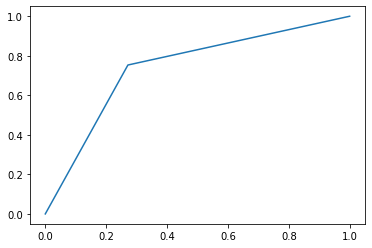

In [100]:
# ROC Curve 
roc = roc_curve(pred_test_df['label_value'], pred_test_df['score'])
plt.plot(roc[0], roc[1])
plt.show()

In [101]:
#AUC - area under the ROC curve
auc = roc_auc_score(pred_test_df['label_value'], pred_test_df['score'])
print(f'AUC: {auc}')

AUC: 0.7409014697039047


# 7. Evaluating Potential Model Biases with Aequitas Toolkit

## Prepare Data For Aequitas Bias Toolkit 

Using the gender and race fields, we will prepare the data for the Aequitas Toolkit.

In [103]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

ae_subset_df = pred_test_df[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()


## Reference Group Selection

Below we have chosen the reference group for our analysis but feel free to select another one.

In [104]:
# test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(clean_xtab, 
                    original_df=ae_df, 
                    ref_groups_dict={'race':'Caucasian', 'gender':'Male'
                                     }, 
                    alpha=0.05, 
                    check_significance=False)


f = Fairness()
fdf = f.get_group_value_fairness(bdf)

get_disparity_predefined_group()


## Race and Gender Bias Analysis for Patient Selection

**Question 12**: For the gender and race fields, please plot two metrics that are important for patient selection below and state whether there is a significant bias in your model across any of the groups along with justification for your statement.

In [105]:
# Plot two metrics

# Is there significant bias in your model for either race or gender?
absolute_metrics = g.list_absolute_metrics(xtab)
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,0,binary 0/1,8142,race,?,223,266,86,39,227,137,176,313,489,17533
1,0,binary 0/1,8142,race,AfricanAmerican,1414,1751,499,325,1426,915,1240,1925,3165,17533
2,0,binary 0/1,8142,race,Asian,54,74,18,9,65,36,45,83,128,17533
3,0,binary 0/1,8142,race,Caucasian,6183,6901,2160,1302,5599,4023,5325,7759,13084,17533
4,0,binary 0/1,8142,race,Hispanic,135,237,47,33,204,88,121,251,372,17533
5,0,binary 0/1,8142,race,Other,133,162,44,24,138,89,113,182,295,17533
6,0,binary 0/1,8142,gender,Female,4320,4834,1497,928,3906,2823,3751,5403,9154,17533
7,0,binary 0/1,8142,gender,Male,3822,4557,1357,804,3753,2465,3269,5110,8379,17533


In [106]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,race,?,0.78,0.73,0.15,0.39,0.27,0.22,0.85,0.61,0.03,0.46,0.36
1,race,AfricanAmerican,0.74,0.74,0.19,0.35,0.26,0.26,0.81,0.65,0.17,0.45,0.39
2,race,Asian,0.80,0.78,0.12,0.33,0.22,0.20,0.88,0.67,0.01,0.42,0.35
3,race,Caucasian,0.76,0.72,0.19,0.35,0.28,0.24,0.81,0.65,0.76,0.47,0.41
4,race,Hispanic,0.73,0.81,0.14,0.35,0.19,0.27,0.86,0.65,0.02,0.36,0.33
5,race,Other,0.79,0.76,0.15,0.33,0.24,0.21,0.85,0.67,0.02,0.45,0.38
6,gender,Female,0.75,0.72,0.19,0.35,0.28,0.25,0.81,0.65,0.53,0.47,0.41
7,gender,Male,0.75,0.73,0.18,0.36,0.27,0.25,0.82,0.64,0.47,0.46,0.39


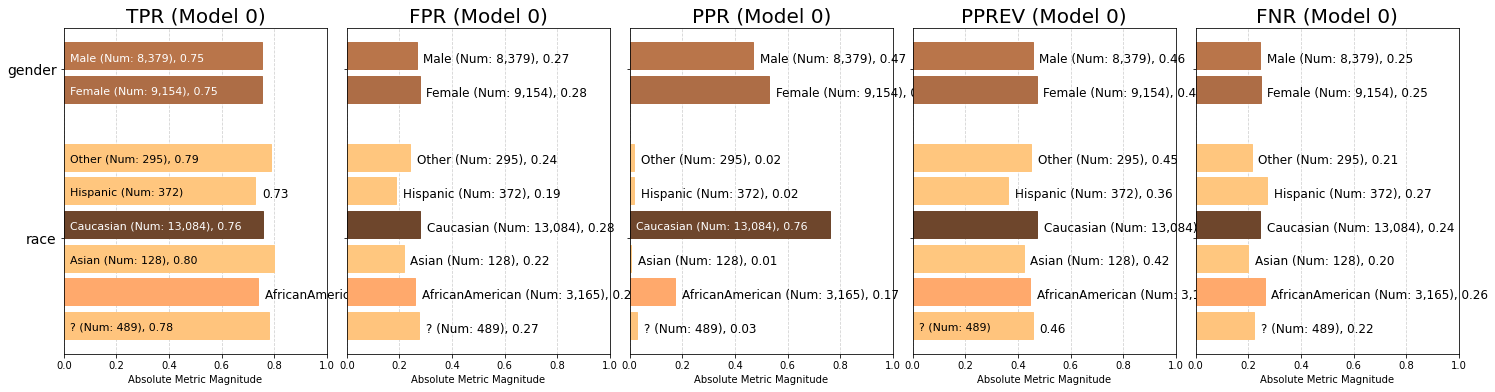

<Figure size 432x288 with 0 Axes>

In [108]:
p = aqp.plot_group_metric_all(xtab, metrics=['tpr', 'fpr', 'ppr', 'pprev', 'fnr'], ncols=5)

From the graph shown we can see no bias in gender, and no major bias also in race for TPR
For PPR there's bias for female, and huge biase for Caucasian race group. 

## Fairness Analysis Example - Relative to a Reference Group 

**Question 13**: Earlier we defined our reference group and then calculated disparity metrics relative to this grouping. Please provide a visualization of the fairness evaluation for this reference group and analyze whether there is disparity.

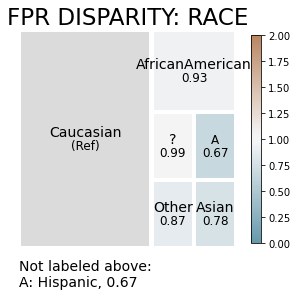

In [109]:
# Reference group fairness plot
fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity', attribute_name='race')

In terms of False Positive Rate, we can see that Hispanics and Asians that do not fit for the program, have somewhat smaller probability of being selected for it, as compared to Caucasian males.
It has to be mentioned though, that there is no extreme FPR disparity in respect to race